In [1]:
!pip install tensorflow_datasets
!pip install tensorflow_recommenders

In [2]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])


user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)


# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)



# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))


Epoch 1/5
25/25 [==============================] - 30s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.1000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0017 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0439 - factorized_top_k/top_100_categorical_accuracy: 0.1010 - loss: 33082.7788 - regularization_loss: 0.0000e+00 - total_loss: 33082.7788
Epoch 2/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.1052 - factorized_top_k/top_100_categorical_accuracy: 0.2117 - loss: 31008.8836 - regularization_loss: 0.0000e+00 - total_loss: 31008.8836
Epoch 3/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 5.7000e-04 - factorized_top_k/top_5_categorical_accu

In [16]:

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=5)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

Epoch 1/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 9.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0120 - factorized_top_k/top_10_categorical_accuracy: 0.0330 - factorized_top_k/top_50_categorical_accuracy: 0.2147 - factorized_top_k/top_100_categorical_accuracy: 0.3689 - loss: 29612.7761 - regularization_loss: 0.0000e+00 - total_loss: 29612.7761
Epoch 2/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0122 - factorized_top_k/top_10_categorical_accuracy: 0.0342 - factorized_top_k/top_50_categorical_accuracy: 0.2280 - factorized_top_k/top_100_categorical_accuracy: 0.3878 - loss: 29450.1423 - regularization_loss: 0.0000e+00 - total_loss: 29450.1423
Epoch 3/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 8.0000e-04 - factorized_top_k/top_5_categorical_accu

In [17]:

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")



Top 3 recommendations for user 42: [b'Rent-a-Kid (1995)' b'House Arrest (1996)' b'Just Cause (1995)']


In [18]:
_, titles = index({"user_id": np.array(["32"]) ,"user_occupation_label": np.array([20])})

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['user_id', 'user_occupation_label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [19]:
index.save('./index_model_epoch10')

INFO:tensorflow:Assets written to: ./index_model_epoch10/assets


INFO:tensorflow:Assets written to: ./index_model_epoch10/assets


In [20]:
new_model = tf.keras.models.load_model('./index_model_epoch10')

In [21]:
# Get some recommendations.
_, new_titles = index(np.array(["42"]))
print(f"Top recommendations for user 42: {new_titles}")


Top recommendations for user 42: [[b'Rent-a-Kid (1995)' b'House Arrest (1996)' b'Just Cause (1995)'
  b'Halloween: The Curse of Michael Myers (1995)' b'Jack (1996)'
  b'Land Before Time III: The Time of the Great Giving (1995) (V)'
  b'Clean Slate (1994)' b'All Dogs Go to Heaven 2 (1996)'
  b'Unstrung Heroes (1995)' b'Only You (1994)']]


In [22]:
!zip -r index_model_epoch10.zip index_model_epoch10

  adding: index_model_epoch10/ (stored 0%)


In [23]:
!zip -r index_model_epoch10.zip index_model_epoch10

updating: index_model_epoch10/ (stored 0%)
  adding: index_model_epoch10/saved_model.pb (deflated 84%)
  adding: index_model_epoch10/assets/ (stored 0%)
  adding: index_model_epoch10/variables/ (stored 0%)
  adding: index_model_epoch10/variables/variables.index (deflated 29%)
  adding: index_model_epoch10/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: index_model_epoch10/keras_metadata.pb (deflated 83%)


In [ ]:
Top recommendations for user 42: [[b'Rent-a-Kid (1995)'
  b'Far From Home: The Adventures of Yellow Dog (1995)'
  b'Winnie the Pooh and the Blustery Day (1968)'
  b'Aristocats, The (1970)' b'Aladdin and the King of Thieves (1996)'
  b'House Arrest (1996)' b'First Knight (1995)' b'Pinocchio (1940)'
  b'Old Yeller (1957)' b'Andre (1994)']]

In [62]:
history = """
Epoch 1/5
25/25 [==============================] - 30s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.1000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0017 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0439 - factorized_top_k/top_100_categorical_accuracy: 0.1010 - loss: 33082.7788 - regularization_loss: 0.0000e+00 - total_loss: 33082.7788
Epoch 2/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.1052 - factorized_top_k/top_100_categorical_accuracy: 0.2117 - loss: 31008.8836 - regularization_loss: 0.0000e+00 - total_loss: 31008.8836
Epoch 3/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 5.7000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0085 - factorized_top_k/top_10_categorical_accuracy: 0.0225 - factorized_top_k/top_50_categorical_accuracy: 0.1441 - factorized_top_k/top_100_categorical_accuracy: 0.2667 - loss: 30417.2299 - regularization_loss: 0.0000e+00 - total_loss: 30417.2299
Epoch 4/5
25/25 [==============================] - 29s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.9000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0106 - factorized_top_k/top_10_categorical_accuracy: 0.0279 - factorized_top_k/top_50_categorical_accuracy: 0.1766 - factorized_top_k/top_100_categorical_accuracy: 0.3140 - loss: 30069.3340 - regularization_loss: 0.0000e+00 - total_loss: 30069.3340
Epoch 5/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0114 - factorized_top_k/top_10_categorical_accuracy: 0.0309 - factorized_top_k/top_50_categorical_accuracy: 0.1986 - factorized_top_k/top_100_categorical_accuracy: 0.3459 - loss: 29812.3138 - regularization_loss: 0.0000e+00 - total_loss: 29812.3138
Epoch 1/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 9.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0120 - factorized_top_k/top_10_categorical_accuracy: 0.0330 - factorized_top_k/top_50_categorical_accuracy: 0.2147 - factorized_top_k/top_100_categorical_accuracy: 0.3689 - loss: 29612.7761 - regularization_loss: 0.0000e+00 - total_loss: 29612.7761
Epoch 2/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0122 - factorized_top_k/top_10_categorical_accuracy: 0.0342 - factorized_top_k/top_50_categorical_accuracy: 0.2280 - factorized_top_k/top_100_categorical_accuracy: 0.3878 - loss: 29450.1423 - regularization_loss: 0.0000e+00 - total_loss: 29450.1423
Epoch 3/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 8.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical_accuracy: 0.0355 - factorized_top_k/top_50_categorical_accuracy: 0.2381 - factorized_top_k/top_100_categorical_accuracy: 0.4022 - loss: 29314.3070 - regularization_loss: 0.0000e+00 - total_loss: 29314.3070
Epoch 4/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 8.9000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0128 - factorized_top_k/top_10_categorical_accuracy: 0.0368 - factorized_top_k/top_50_categorical_accuracy: 0.2460 - factorized_top_k/top_100_categorical_accuracy: 0.4144 - loss: 29198.7438 - regularization_loss: 0.0000e+00 - total_loss: 29198.7438
Epoch 5/5
25/25 [==============================] - 28s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.4000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0134 - factorized_top_k/top_10_categorical_accuracy: 0.0379 - factorized_top_k/top_50_categorical_accuracy: 0.2532 - factorized_top_k/top_100_categorical_accuracy: 0.4243 - loss: 29100.4352 - regularization_loss: 0.0000e+00 - total_loss: 29100.4352
"""

In [63]:
history = history.split("[==============================]")

In [64]:
history = [h for h in history if "step" in h]

In [65]:
# history = [h.split('-') for h in history]

In [66]:
top_1_acc = []
top_5_acc = []
top_10_acc = []
top_50_acc = []
top_100_acc = []
loss = []
regularization_loss = []
total_loss = []

In [67]:
history[0]

' - 30s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.1000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0017 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0439 - factorized_top_k/top_100_categorical_accuracy: 0.1010 - loss: 33082.7788 - regularization_loss: 0.0000e+00 - total_loss: 33082.7788\nEpoch 2/5\n25/25 '

In [68]:
TOP_1 = 'top_1_categorical_accuracy'
TOP_5 = 'top_5_categorical_accuracy'
TOP_10 = 'top_10_categorical_accuracy'
TOP_50 = 'top_50_categorical_accuracy'
TOP_100 = 'top_100_categorical_accuracy'
LOSS  = '- loss'
R_LOSS = 'regularization_loss'
TOTAL_LOSS = 'total_loss'


In [90]:
def parse(key, h) : 
  h = h.split(key)[1]

  val = h.split(" -")[0].strip()
  val = val[1:]

  if "Epoch" in val : 
    val = val.split("\n")[0]
  
  val = val.strip()
  return float(val)

In [94]:
for h in history : 
  a = parse(TOP_1, h)
  k = parse(TOP_5, h)
  b = parse(TOP_10, h)
  c = parse(TOP_50, h)
  d = parse(TOP_100, h)
  e = parse(LOSS, h)
  f = parse(R_LOSS, h)
  g = parse(TOTAL_LOSS, h)
  print (a, b, c, d, e, f, g)
  top_1_acc.append(a)
  top_5_acc.append(k)
  top_10_acc.append(b)
  top_50_acc.append(c)
  top_100_acc.append(d)
  loss.append(e)
  regularization_loss.append(f)
  total_loss.append(g)
  

0.00011 0.0051 0.0439 0.101 33082.7788 0.0 33082.7788
0.00022 0.015 0.1052 0.2117 31008.8836 0.0 31008.8836
0.00057 0.0225 0.1441 0.2667 30417.2299 0.0 30417.2299
0.00079 0.0279 0.1766 0.314 30069.334 0.0 30069.334
0.00075 0.0309 0.1986 0.3459 29812.3138 0.0 29812.3138
0.00092 0.033 0.2147 0.3689 29612.7761 0.0 29612.7761
0.00075 0.0342 0.228 0.3878 29450.1423 0.0 29450.1423
0.0008 0.0355 0.2381 0.4022 29314.307 0.0 29314.307
0.00089 0.0368 0.246 0.4144 29198.7438 0.0 29198.7438
0.00074 0.0379 0.2532 0.4243 29100.4352 0.0 29100.4352


In [95]:
from matplotlib import pyplot as plt

In [99]:
def quick_plot(title, array) : 
  plt.title(title)
  plt.plot(array)

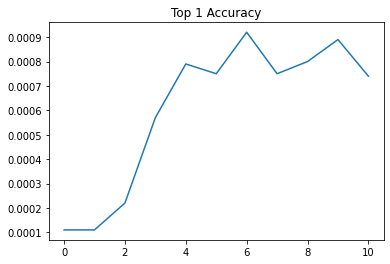

In [100]:
quick_plot("Top 1 Accuracy", top_1_acc)

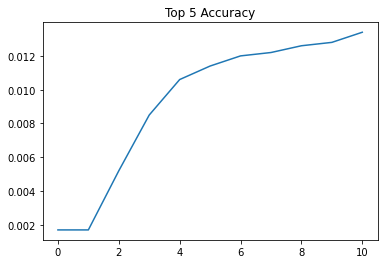

In [102]:
quick_plot("Top 5 Accuracy", top_5_acc)

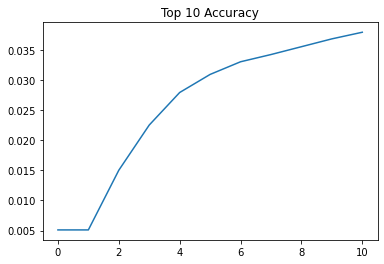

In [103]:
quick_plot("Top 10 Accuracy", top_10_acc)

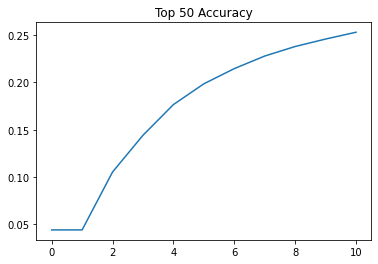

In [104]:
quick_plot("Top 50 Accuracy", top_50_acc)

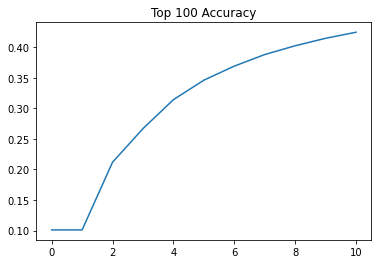

In [105]:
quick_plot("Top 100 Accuracy", top_100_acc)

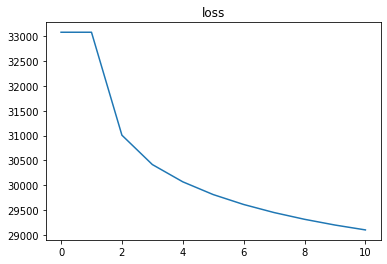

In [106]:
quick_plot("loss", loss)

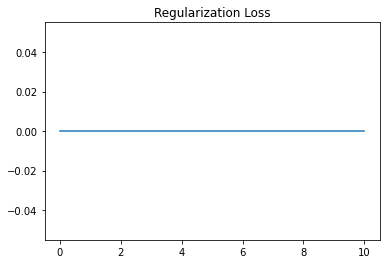

In [107]:
quick_plot("Regularization Loss", regularization_loss)

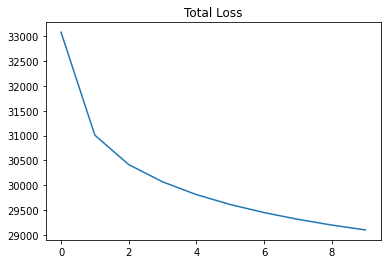

In [108]:
quick_plot("Total Loss", total_loss)

In [109]:
# For matrix factorization code : 

vals = """
iteration 50 :
train mse: 5.056022536249493

iteration 100 :
train mse: 3.289468719070871

iteration 150 :
train mse: 2.613344417374374

iteration 200 :
train mse: 2.2236954509546156

iteration 250 :
train mse: 1.965755218180462

iteration 300 :
train mse: 1.7808267723880815

iteration 350 :
train mse: 1.6413109011833664

iteration 400 :
train mse: 1.5322989755099927

iteration 450 :
train mse: 1.4449001839234288

iteration 500 :
train mse: 1.3734143343708516

iteration 550 :
train mse: 1.3139862912567124

iteration 600 :
train mse: 1.2639029732611926

iteration 650 :
train mse: 1.2211967682867597

iteration 700 :
train mse: 1.1844071590150393

iteration 750 :
train mse: 1.1524298018121988

iteration 800 :
train mse: 1.1244168686020837
"""

In [110]:
vals = vals.split("\n")
vals = [v for v in vals if "mse" in v]

In [111]:
vals = [float(v.split(":")[1].strip()) for v in vals]

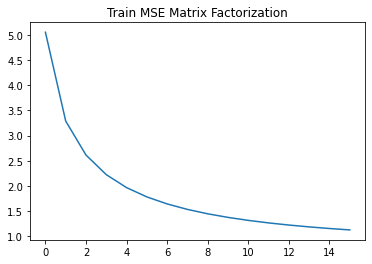

In [113]:
quick_plot("Train MSE Matrix Factorization", vals)